In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings about potential convergence issues in XGBoost
from warnings import filterwarnings
filterwarnings('ignore')

In [25]:
# Load the data from the CSV file
df = pd.read_csv('train.csv')
df.head()  # Display the first few rows of the DataFrame

# Check the shape of the DataFrame (number of rows and columns)
df.shape

# Preprocessing steps
print(df.isnull().sum())  # Check for missing values in each column
df.drop_duplicates(inplace=True)  # Remove duplicate rows
df.dropna(subset=['ProductId', 'Quantity', 'Amount'], inplace=True)  # Remove rows with missing values in specified columns

# Convert 'Date' column to datetime format and extract year, month, and quarter
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

# Filter out rows with negative quantities or amounts
df = df[(df['Quantity'] >= 0) & (df['Amount'] >= 0)]

# Sort the DataFrame by date in ascending order
df.sort_values(by='Date', inplace=True)

# Encode categorical features (CustomerId and ProductId) using LabelEncoder
le_cust = LabelEncoder()
le_prod = LabelEncoder()
df['CustomerId'] = le_cust.fit_transform(df['CustomerId'])
df['ProductId'] = le_prod.fit_transform(df['ProductId'])

# Create mapping dictionaries for original and encoded values
customer_mapping = pd.DataFrame({
    'OriginalCustomerId': le_cust.classes_,
    'EncodedCustomerId': range(len(le_cust.classes_))
})

product_mapping = pd.DataFrame({
    'OriginalProductId': le_prod.classes_,
    'EncodedProductId': range(len(le_prod.classes_))
})

InvoiceId       0
Date            0
CustomerId      0
ProductId     384
Quantity      384
Amount        384
dtype: int64


In [26]:
# Split the data into features (X) and target (y)
X = df[['CustomerId', 'ProductId', 'Year', 'Month', 'Quantity']]  # Features
y = df['Amount']  # Target

# Create the train and test datasets based on the years
X_train = X[(X['Year'] == 2021) | (X['Year'] == 2022)]  # Train features (2021 and 2022)
y_train = y[(df['Year'] == 2021) | (df['Year'] == 2022)]  # Train target (2021 and 2022)

X_test = X[X['Year'] == 2023]  # Test features (2023)
y_test = y[df['Year'] == 2023]  # Test target (2023)


# Output the shapes of the train and test sets
print("Original Data Shape:", df_train.shape)
print("Training Features Shape (X_train):", X_train.shape)
print("Training Target Shape (y_train):", y_train.shape)
print("Test Features Shape (X_test):", X_test.shape)
print("Test Target Shape (y_test):", y_test.shape)

Original Data Shape: (110204, 7)
Training Features Shape (X_train): (110204, 5)
Training Target Shape (y_train): (110204,)
Test Features Shape (X_test): (63450, 5)
Test Target Shape (y_test): (63450,)


R square value (Train) =  0.9543708949085029
R square value(Test) =  0.870935963137477


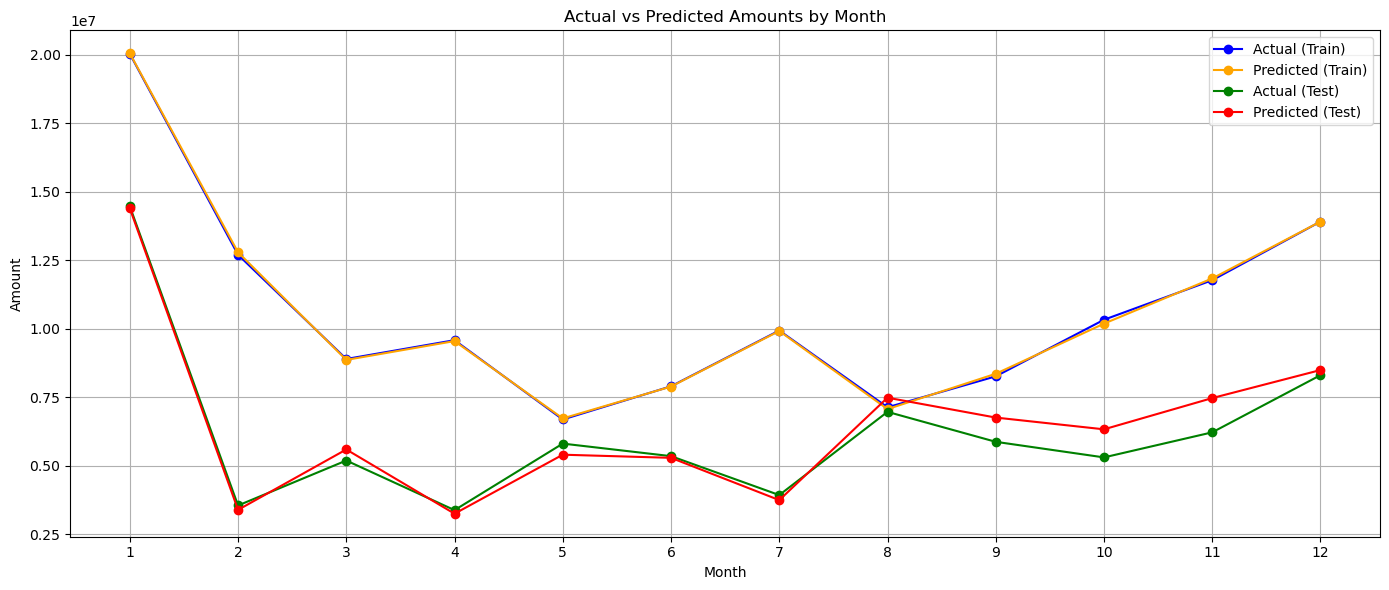

In [27]:
from xgboost import XGBRegressor
regressor = XGBRegressor()
regressor.fit(X_train, y_train)

from sklearn import metrics

# Prediction on training data
training_data_prediction = regressor.predict(X_train)

# R squared value
r2_train = metrics.r2_score(y_train, training_data_prediction)
print('R square value (Train) = ', r2_train)

# Prediction on testing data
test_data_prediction = regressor.predict(X_test)

# R squared value
r2_test = metrics.r2_score(y_test, test_data_prediction)
print('R square value(Test) = ', r2_test)

train_results = pd.DataFrame({
    'Month': X_train['Month'].values,
    'Actual': y_train,
    'Predicted': training_data_prediction
})

# Add Month to test_results
test_results = pd.DataFrame({
    'Month': X_test['Month'].values,
    'Actual': y_test,
    'Predicted': test_data_prediction
})


# Aggregate by month for training data
train_monthly = train_results.groupby('Month').agg({'Actual': 'sum', 'Predicted': 'sum'}).reset_index()

# Aggregate by month for test data
test_monthly = test_results.groupby('Month').agg({'Actual': 'sum', 'Predicted': 'sum'}).reset_index()

# Plotting the results
plt.figure(figsize=(14, 6))

# Training data plot
plt.plot(train_monthly['Month'], train_monthly['Actual'], label='Actual (Train)', color='blue', marker='o')
plt.plot(train_monthly['Month'], train_monthly['Predicted'], label='Predicted (Train)', color='orange', marker='o')

# Test data plot
plt.plot(test_monthly['Month'], test_monthly['Actual'], label='Actual (Test)', color='green', marker='o')
plt.plot(test_monthly['Month'], test_monthly['Predicted'], label='Predicted (Test)', color='red', marker='o')

# Customize the plot
plt.title('Actual vs Predicted Amounts by Month')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.xticks(range(1, 13))  # Assuming months are 1-12
plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, training_data_prediction))
print(f'RMSE for Training Data: {rmse_train}')

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test, test_data_prediction))
print(f'RMSE for Test Data: {rmse_test}')


RMSE for Training Data: 1146.3105202472927
RMSE for Test Data: 2058.1418233524687


In [29]:
# Calculate mean and range for the target variable
mean_train = y_train.mean()
mean_test = y_test.mean()

range_train = y_train.max() - y_train.min()
range_test = y_test.max() - y_test.min()

# NRMSE (mean normalization)
nrmse_mean_train = rmse_train / mean_train
nrmse_mean_test = rmse_test / mean_test

# NRMSE (range normalization)
nrmse_range_train = rmse_train / range_train
nrmse_range_test = rmse_test / range_test

# Print the results
print(f"Normalized RMSE (Mean) for Training Data: {nrmse_mean_train}")
print(f"Normalized RMSE (Mean) for Test Data: {nrmse_mean_test}")

print(f"Normalized RMSE (Range) for Training Data: {nrmse_range_train}")
print(f"Normalized RMSE (Range) for Test Data: {nrmse_range_test}")

Normalized RMSE (Mean) for Training Data: 0.9936933604870148
Normalized RMSE (Mean) for Test Data: 1.7560686280760949
Normalized RMSE (Range) for Training Data: 0.004204484009122993
Normalized RMSE (Range) for Test Data: 0.00805219805693454
